In [1]:
import pandas as pd

df1 = pd.read_csv("eva-only-larger-sample-annotated.csv").dropna()
df1 = df1.replace({"match": {True: "match", False: "no-match"}})

df2 = pd.read_csv("fast-annotated.csv").dropna().drop(
    columns=["pred", "match_proba", "no-match_proba"],
)
df2 = df2.rename(columns={"label": "match"})

df3 = pd.read_csv("fast-annotated-2.csv").dropna().drop(
    columns=["pred", "match_proba", "no-match_proba"],
)
df3 = df3.rename(columns={"label": "match"})

df = pd.concat([df1, df2, df3], ignore_index=True)

# drop duplicates
df = df.drop_duplicates(subset=["dev_details", "author_details"])
df.sample(3)

,dev_details,author_details,match
311,username: rohskopf;\nname: None;\nemail: None;...,name: Andrew Dale Rohskopf;\nrepos: https://gi...,match
1984,username: etienne-s;\nname: None;\nemail: None...,name: Stefan Müller;\nrepos: https://github.co...,no-match
2760,username: dario-coscia;\nname: Dario Coscia;\n...,name: Dario Coscia;\nrepos: https://github.com...,match


In [2]:
df.match.value_counts()

no-match    2365
match        399
Name: match, dtype: int64

In [3]:
from sentence_transformers.util import cos_sim
from sentence_transformers import SentenceTransformer
from tqdm import tqdm

def from_details_to_dicts(
    dev_details: str,
    author_details: str,
    model: SentenceTransformer | None = None,
    rtype: str = "cos_sim",
) -> dict[str, float]:
    # If no model, create
    if model is None:
        model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

    dev_items = dev_details.replace("\n", "").split(";")
    author_items = author_details.replace("\n", "").split(";")
    dev_dict = {
        pair[0].strip(): pair[1].strip()
        for pair in [item.split(":", 1) for item in dev_items]
        if len(pair) == 2
    }
    author_dict = {
        pair[0].strip(): pair[1].strip()
        for pair in [item.split(":", 1) for item in author_items]
        if len(pair) == 2
    }

    # Remove "repos" keys 
    dev_dict.pop("repos", None)
    author_dict.pop("repos", None)

    # # Remove co_contributors from dev_embedding_dict
    # dev_dict.pop("co_contributors", None)

    # # Remove co_authors from author_embedding_dict
    # author_dict.pop("co_authors", None)

    # Create embedding for each part
    dev_values_embeddings = model.encode(list(dev_dict.values())).tolist()
    author_values_embeddings = model.encode(list(author_dict.values())).tolist()
    dev_embedding_dict = {
        key: value
        for key, value in zip(
            dev_dict.keys(),
            dev_values_embeddings,
            strict=True,
        )
    }
    author_embedding_dict = {
        key: value
        for key, value in zip(
            author_dict.keys(),
            author_values_embeddings,
            strict=True,
        )
    }
    
    # Create interactions by creating pairwise combinations
    this_x = {}
    for dev_key, dev_value in dev_embedding_dict.items():
        for author_key, author_value in author_embedding_dict.items():
            pairwise_key = f"dev-{dev_key}---author-{author_key}"
            if rtype == "cos_sim":
                this_x[pairwise_key] = cos_sim(dev_value, author_value).item()
            elif rtype == "dim_split":
                for i, dev_i_v in enumerate(dev_value):
                    this_x[f"{pairwise_key}---dim-{i}"] = dev_i_v * author_value[i]
            else:
                raise ValueError(f"Unknown rtype {rtype}")

    return this_x

In [4]:
# for each row construct string of combination dev and author details
embed_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
cos_sim_x = []
for _, row in tqdm(
    df.iterrows(),
    total=len(df),
):
    # Add to list
    cos_sim_x.append(from_details_to_dicts(
        row.dev_details,
        row.author_details,
        embed_model,
        rtype="cos_sim",
    ))


cos_sim_df = pd.DataFrame(cos_sim_x)
cos_sim_df["match"] = df.match
cos_sim_df.sample(3)

100%|██████████| 2764/2764 [00:45<00:00, 60.14it/s]


,dev-username---author-name,dev-username---author-co_authors,dev-name---author-name,dev-name---author-co_authors,dev-email---author-name,dev-email---author-co_authors,dev-co_contributors---author-name,dev-co_contributors---author-co_authors,match
260,0.104014,0.098448,0.199529,0.072450,0.018964,-0.049432,0.227279,0.133185,no-match
2486,0.152306,0.184301,0.216027,0.145936,0.175814,0.126650,0.195167,0.510661,no-match
2223,0.130462,0.042307,0.277604,0.080287,0.177156,0.134267,0.114536,0.247739,no-match


pre: 0.9805198555755863, rec: 0.9801084990958409, f1: 0.9802599089420949


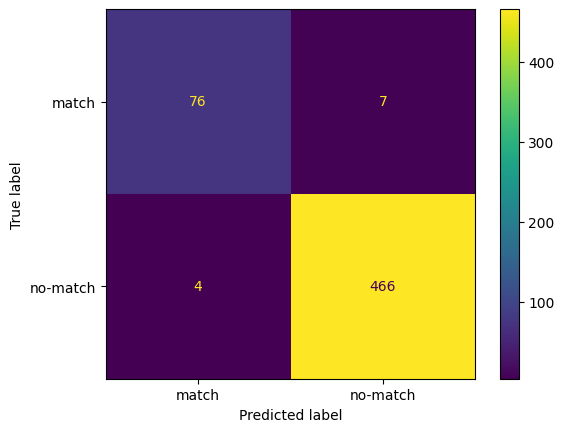

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import precision_recall_fscore_support, ConfusionMatrixDisplay
# Train test split
cos_sim_x_train, cos_sim_x_test, y_train, y_test = train_test_split(
    cos_sim_df.drop(columns=["match"]),
    cos_sim_df.match,
    test_size=0.2,
    stratify=cos_sim_df.match,
    shuffle=True,
    random_state=12
)

# Train model
cos_sim_model = LogisticRegressionCV(
    cv=10,
    max_iter=1000,
    random_state=12,
    class_weight="balanced",
).fit(
    cos_sim_x_train, y_train
)

# Evaluate
cos_sim_y_pred = cos_sim_model.predict(cos_sim_x_test)
cos_sim_precision, cos_sim_recall, cos_sim_f1, _ = precision_recall_fscore_support(
    y_test, cos_sim_y_pred, average="weighted"
)
print(
    f"pre: {cos_sim_precision}, "
    f"rec: {cos_sim_recall}, "
    f"f1: {cos_sim_f1}"
)

ConfusionMatrixDisplay.from_predictions(cos_sim_y_pred, y_test)

In [6]:
from eli5.sklearn import explain_linear_regressor_weights

explain_linear_regressor_weights(
    cos_sim_model,
    feature_names=cos_sim_df.drop(columns=["match"]).columns.tolist(),
)

Weight?,Feature
+0.172,<BIAS>
+0.018,dev-co_contributors---author-name
+0.017,dev-name---author-co_authors
+0.004,dev-username---author-co_authors
-0.002,dev-email---author-co_authors
-0.003,dev-co_contributors---author-co_authors
-0.031,dev-email---author-name
-0.110,dev-username---author-name
-0.235,dev-name---author-name


In [7]:
dim_split_x = []
for _, row in tqdm(
    df.iterrows(),
    total=len(df),
):
    # Add to list
    dim_split_x.append(from_details_to_dicts(
        row.dev_details,
        row.author_details,
        embed_model,
        rtype="dim_split",
    ))

dim_split_df = pd.DataFrame(dim_split_x)
dim_split_df["match"] = df.match
dim_split_df.sample(3)

100%|██████████| 2764/2764 [00:43<00:00, 64.12it/s]


,dev-username---author-name---dim-0,dev-username---author-name---dim-1,dev-username---author-name---dim-2,dev-username---author-name---dim-3,dev-username---author-name---dim-4,dev-username---author-name---dim-5,dev-username---author-name---dim-6,dev-username---author-name---dim-7,dev-username---author-name---dim-8,dev-username---author-name---dim-9,...,dev-co_contributors---author-co_authors---dim-375,dev-co_contributors---author-co_authors---dim-376,dev-co_contributors---author-co_authors---dim-377,dev-co_contributors---author-co_authors---dim-378,dev-co_contributors---author-co_authors---dim-379,dev-co_contributors---author-co_authors---dim-380,dev-co_contributors---author-co_authors---dim-381,dev-co_contributors---author-co_authors---dim-382,dev-co_contributors---author-co_authors---dim-383,match
1922,0.008335,0.001583,-0.000237,0.000590,-0.001291,-0.003315,0.015720,0.001089,0.001433,-0.000069,...,0.003662,-0.000787,-0.000162,0.001356,0.00097,0.008243,0.000424,-0.000568,-0.000155,match
1645,-0.000152,0.000349,0.001279,-0.002544,0.000237,0.000484,0.005476,-0.000301,-0.000499,-0.001805,...,0.001361,0.002845,0.003531,0.000941,-0.00158,-0.000079,0.003421,0.001658,-0.000096,no-match
2689,0.004391,0.001918,-0.001325,-0.000394,-0.000313,-0.005583,0.001603,0.000070,-0.005450,0.003761,...,-0.004078,-0.002279,-0.000138,-0.000013,0.00089,0.003688,0.000120,0.000911,0.000220,no-match


pre: 0.983652650292612, rec: 0.9837251356238698, f1: 0.9836825496584962


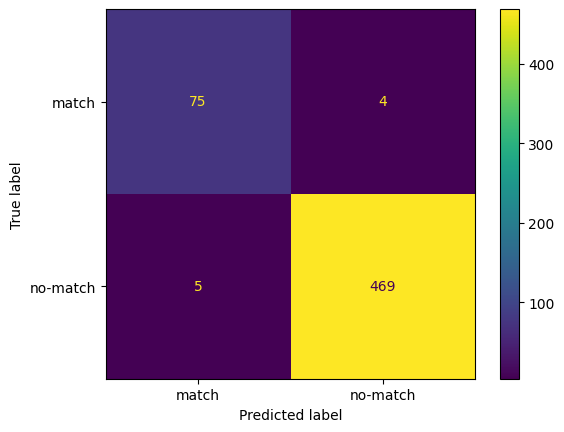

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import precision_recall_fscore_support, ConfusionMatrixDisplay
# Train test split
dim_split_x_train, dim_split_x_test, y_train, y_test = train_test_split(
    dim_split_df.drop(columns=["match"]),
    dim_split_df.match,
    test_size=0.2,
    stratify=dim_split_df.match,
    shuffle=True,
    random_state=12
)

# Train model
dim_split_model = LogisticRegressionCV(
    cv=10,
    max_iter=1000,
    random_state=12,
    class_weight="balanced",
).fit(
    dim_split_x_train, y_train
)

# Evaluate
dim_split_y_pred = dim_split_model.predict(dim_split_x_test)
dim_split_precision, dim_split_recall, dim_split_f1, _ = precision_recall_fscore_support(
    y_test, dim_split_y_pred, average="weighted"
)
print(
    f"pre: {dim_split_precision}, "
    f"rec: {dim_split_recall}, "
    f"f1: {dim_split_f1}"
)

ConfusionMatrixDisplay.from_predictions(dim_split_y_pred, y_test)

In [9]:
from eli5.sklearn import explain_linear_regressor_weights

explain_linear_regressor_weights(
    dim_split_model,
    top=(20, 20),
    feature_names=dim_split_df.drop(columns=["match"]).columns.tolist(),
)

Weight?,Feature
+17.680,dev-email---author-co_authors---dim-142
+17.335,dev-name---author-co_authors---dim-141
+16.380,dev-name---author-co_authors---dim-80
+15.207,dev-co_contributors---author-name---dim-334
+14.884,dev-co_contributors---author-name---dim-32
+14.830,dev-co_contributors---author-name---dim-6
+14.709,dev-name---author-co_authors---dim-250
+14.641,dev-name---author-co_authors---dim-347
+14.632,dev-co_contributors---author-name---dim-307
+14.450,dev-name---author-co_authors---dim-176


In [10]:
# Use model on a sample of the rest
import pandas as pd
the_full_set = pd.read_csv("rs_graph/data/files/author-dev-linker-annotation-dataset.csv").drop(columns=["similarity"])

# Drop rows in the original dataset that are in the sample
the_full_set = the_full_set[~the_full_set.dev_details.isin(df.dev_details)]

# Take sample and encode
sample = the_full_set.sample(1000, random_state=42)
encoded_sample = pd.DataFrame([
    from_details_to_dicts(
        row.dev_details,
        row.author_details,
        embed_model,
        rtype="dim_split",
    )
    for _, row in sample.iterrows()
])
sample["pred"] = dim_split_model.predict(encoded_sample)
sample.pred.value_counts()

no-match    878
match       122
Name: pred, dtype: int64

In [11]:
sample.sample(10)

,dev_details,author_details,pred
6832,username: aloriba;\nname: None;\nemail: None;\...,name: Brian S Gerwe;\nrepos: https://github.co...,no-match
6298,username: ahayman314;\nname: Andrew Hayman;\ne...,name: Daniel J. Egger;\nrepos: https://github....,no-match
5121,username: Tarrasch;\nname: Arash Rouhani;\nema...,name: Tobias Kunz;\nrepos: https://github.com/...,no-match
13472,username: gnwong;\nname: George N. Wong;\nemai...,name: George N. Wong;\nrepos: https://github.c...,match
21691,username: patrickherring-TRI;\nname: Patrick H...,name: Daniel Schweigert;\nrepos: https://githu...,no-match
27317,username: wiso;\nname: Ruggero Turra;\nemail: ...,name: Lukas Alexander Heinrich;\nrepos: https:...,no-match
10216,username: cychan-lbnl;\nname: Cy P Chan;\nemai...,name: Cy Chan;\nrepos: https://github.com/AMRe...,match
24666,username: skalarproduktraum;\nname: Ulrik Günt...,name: Jed Simson;\nrepos: https://github.com/J...,no-match
18059,username: lm1909;\nname: Maximilian Lutz;\nema...,name: Johnnie Gray;\nrepos: https://github.com...,no-match
17446,username: ktbolt;\nname: Dave Parker;\nemail: ...,name: Shawn Christopher Shadden;\nrepos: https...,no-match


In [12]:
sample.loc[sample.pred == "match"].sample(10)

,dev_details,author_details,pred
4253,username: PsyChiLin;\nname: Chi-Lin Yu;\nemail...,name: Chi-Lin Yu;\nrepos: https://github.com/P...,match
11694,username: egonw;\nname: Egon Willighagen;\nema...,name: Egon L. Willighagen;\nrepos: https://git...,match
15867,username: joaonmatos;\nname: João Nuno Matos;\...,name: João Paulo Da Silva Bispo;\nrepos: https...,match
23877,username: sarahllpetersen;\nname: Sarah Peters...,name: Sarah Petersen;\nrepos: https://github.c...,match
22328,username: pratikvn;\nname: Pratik Nayak;\nemai...,name: Pratik Nayak;\nrepos: https://github.com...,match
16525,username: jvencels;\nname: Juris Vencels;\nema...,name: Juris Vencels;\nrepos: https://github.co...,match
15983,username: johnb30;\nname: John Beieler;\nemail...,name: John Beieler;\nrepos: https://github.com...,match
19967,username: mk-95;\nname: Mokbel Karam;\nemail: ...,name: Mokbel Karam;\nrepos: https://github.com...,match
10929,username: dhrubaditya;\nname: Dhrubaditya MITR...,name: Dhrubaditya Mitra;\nrepos: https://githu...,match
7999,username: babinyurii;\nname: Yuriy Babin;\nema...,name: Yuriy Y. Babin;\nrepos: https://github.c...,match


In [14]:
# Find low proba matches
probas = dim_split_model.predict_proba(encoded_sample)
sample["match_proba"] = probas[:, 0]
sample["no-match_proba"] = probas[:, 1]
sample.sample(10)

,dev_details,author_details,pred,match_proba,no-match_proba
22824,username: rdbisme;\nname: Ruben Di Battista;\n...,name: James Benjamin Scoggins;\nrepos: https:/...,no-match,0.002039,0.997961
10113,username: csoderberg;\nname: None;\nemail: Non...,name: Timothy P. York;\nrepos: https://github....,no-match,0.028142,0.971858
12820,username: franzbischoff;\nname: Francisco Bisc...,name: Tyler Marrs;\nrepos: https://github.com/...,no-match,0.001105,0.998895
4270,username: QRK1TT13;\nname: None;\nemail: None;...,name: Coenraad J. Neijssel;\nrepos: https://gi...,no-match,0.000672,0.999328
16715,username: kanodiaayush;\nname: Ayush Kanodia;\...,name: Ayush Kanodia;\nrepos: https://github.co...,match,0.999922,0.000078
8586,username: bluescarni;\nname: Francesco Biscani...,name: Francesco Biscani;\nrepos: https://githu...,match,0.985013,0.014987
6538,username: alanocallaghan;\nname: Alan O'Callag...,name: Alicia N. Schep;\nrepos: https://github....,no-match,0.003298,0.996702
15779,username: jmcurran;\nname: James Curran;\nemai...,name: James Michael Curran;\nrepos: https://gi...,match,0.971566,0.028434
20164,username: monkeywithacupcake;\nname: jess;\nem...,name: Sebastien Binet;\nrepos: https://github....,no-match,0.005693,0.994307
16870,username: kawindme;\nname: None;\nemail: None;...,name: Kai-lukas Windmeier;\nrepos: https://git...,no-match,0.015917,0.984083


In [15]:
sample.loc[sample.pred == "match"].sort_values(by="match_proba").head(10)

,dev_details,author_details,pred,match_proba,no-match_proba
11785,username: elbeejay;\nname: J. Hariharan;\nemai...,name: Jayaram Athreya Hariharan;\nrepos: https...,match,0.539190,0.460810
16159,username: josejimenezluna;\nname: José Jiménez...,name: José Jiménez;\nrepos: https://github.com...,match,0.541115,0.458885
22685,username: ramiyaari;\nname: None;\nemail: None...,name: Rami Yaari;\nrepos: https://github.com/r...,match,0.549451,0.450549
18835,username: martcaro;\nname: Marta Caro Martínez...,name: Marta Caro-mart́ınez;\nrepos: https://gi...,match,0.552305,0.447695
21542,username: ozolotov;\nname: None;\nemail: None;...,name: Oleg I. Zolotov;\nrepos: https://github....,match,0.558502,0.441498
8501,username: bjodah;\nname: Bjorn;\nemail: None;\...,name: Björn Dahlgren;\nrepos: www.github.com/b...,match,0.578247,0.421753
4803,username: SeriousHorncat;\nname: Angelina Uno-...,name: Angelina E. Uno-Antonison;\nrepos: https...,match,0.599360,0.400640
25678,username: telegraphic;\nname: Danny Price;\nem...,name: Daniel Charles Price;\nrepos: https://gi...,match,0.617173,0.382827
623,username: AtomAnu;\nname: Atom Anuchitanukul;\...,name: Atijit Anuchitanukul;\nrepos: https://gi...,match,0.651669,0.348331
1270,username: Dado1513;\nname: Davide Caputo;\nema...,name: David J. Caputo;\nrepos: https://github....,match,0.657609,0.342391
